# Notebook

In [1]:
%cd ..
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Any
from models.linear import LinearRegression
from preprocessing import PolynomialFeatures
from misc.loss_fns import RMS

C:\Users\realq\Desktop\DL_solutions


In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

The synthetic dataset was by choosing $N=10$ values of $x_n$ spaced uniformly in the range $[0,1]$ with the associated target value 
obtained first by computing the value of $y_n=\sin(2\pi{x_n})$ and then adding a small level of Gaussian noise (with standard deviation 
$\sigma=0.3$)

In [3]:
def sin2pi(x: np.ndarray) -> np.ndarray:
    '''
    Returns sin(2*pi*x) for an input NDArray x
    '''
    return np.sin(2 * np.pi * x)

def gen_data(N: int = 10, dist: Callable[[np.ndarray], Any] = sin2pi,
             std: float = 0.3, rng = np.random.default_rng(19)) -> tuple[np.ndarray, np.ndarray]:
    '''
    Generates N Data points according to an underlying distribution with added Gaussian noise.

    :param N: number of points
    :param dist: distribution to generate points from
    :param std: standard deviation of the Gaussian Noise to sample from
    :param rng: rng seed to sample Gaussian from
    :return: ordered pair of the data, 
    '''
    x = np.linspace(0, 1, N)
    y = dist(x)
    y += rng.normal(0, std, y.shape)
    return x, y

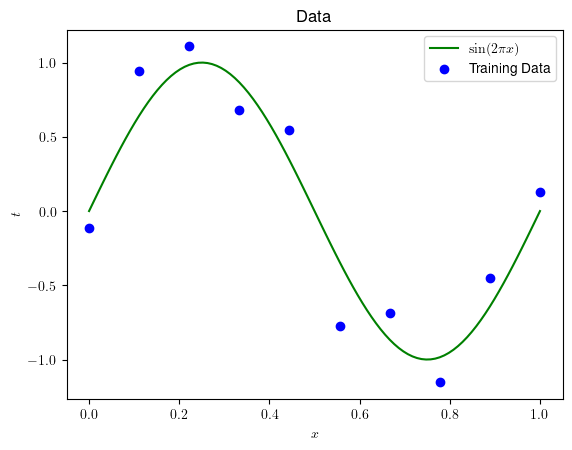

In [4]:
train_in, train_out = gen_data()
curve_x: np.ndarray = np.linspace(0, 1, 100)
curve_y: np.ndarray = sin2pi(curve_x)

plt.plot(curve_x, curve_y, color = 'g', label=r'$\sin(2\pi{x})$')
plt.scatter(train_in, train_out, facecolor = 'b', label='Training Data')
plt.title('Data')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$') 
plt.legend()
plt.show()

One simple appraoch to curve fitting regression problems is the use of linear models (models linear in the unknown parameters). In our case, we start with
polynomial functions which can alternatively be thought of as a dot product between the weight vector $\textbf{w}$ and the output of the basis function 
$\phi(x)=[1,x,\cdots,x^M]^{T}$, ie. 

$$
y(x,\textbf{w})=\sum_{j=0}^{m}w_j{x^j}=\textbf{w}^{T}\phi(x)
$$

A commonly used method to determine optimal $w$ is through the minimization of the $L^2$ loss 

$$
E(\textbf{w})=\frac{1}{2}\sum_{n-1}^{N}\{y(x_n,\textbf{w})-t_n\}^2
$$
The corresponding fits for several values of the hyperparameter $M$ are shown below:

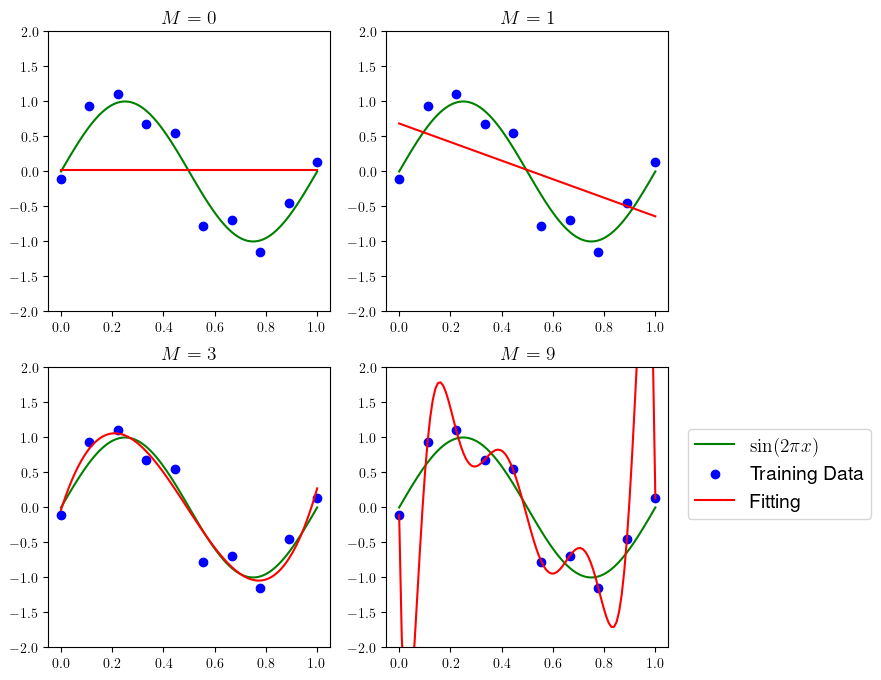

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

for i, degree in enumerate([0,1,3,9]):
    features = PolynomialFeatures(degree)
    model = LinearRegression(degree, basis=features.transform)
    model.fit(train_in, train_out)

    y = model.run(curve_x)
    subplot = ax[i // 2, i % 2]
    subplot.plot(curve_x, curve_y, color = 'g', label=r'$\sin(2\pi{x})$')
    subplot.scatter(train_in, train_out, facecolor = 'b', label = 'Training Data')
    subplot.plot(curve_x, y, color = 'r', label='Fitting')
    subplot.set_ylim(-2,2)
    subplot.set_title(r'$M={}$'.format(degree), fontsize = 14)

plt.legend(bbox_to_anchor=(1, 0.85), loc=2, borderaxespad=1, fontsize=14)
plt.show()

Note the $M=9$ case shows *over-fitting*. We can calculate on the training data the *root-mean-square(RMS)* error to compare the quality of the results on
both the training and test set for various values of $M$.

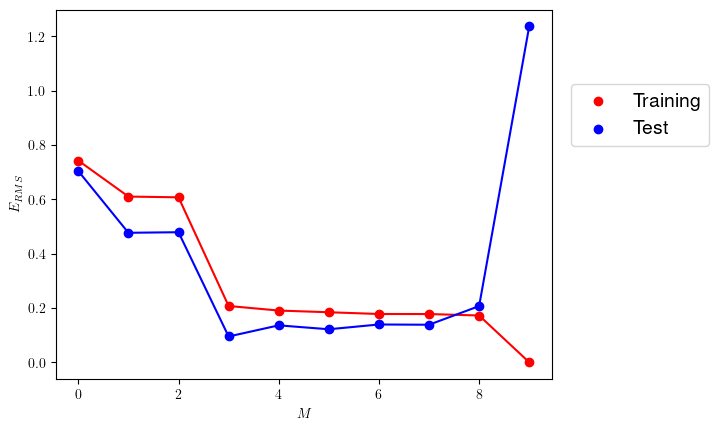

In [6]:
m: list[int] = [i for i in range(10)]
rms_train: list[np.float32] = []
rms_test: list[np.float32] = []
for degree in m:
    features = PolynomialFeatures(degree)
    model = LinearRegression(degree, features.transform)
    model.fit(train_in, train_out)

    y_train = model.run(train_in)
    y_test = model.run(curve_x)

    RMS_train = RMS(y_train, train_out)
    RMS_test = RMS(y_test, curve_y)

    rms_train.append(RMS_train)
    rms_test.append(RMS_test)

plt.scatter(m, rms_train, c = 'r', label='Training')
plt.plot(m, rms_train, c = 'r')
plt.scatter(m, rms_test, c = 'b', label = 'Test')
plt.plot(m, rms_test, c = 'b')
plt.xlabel(r'$M$')
plt.ylabel(r'$E_{RMS}$')
plt.legend(bbox_to_anchor=(1, 0.85), loc=2, borderaxespad=1, fontsize=14)
plt.show()

If, however we have more data points then the $M=9$ model fairs much better:

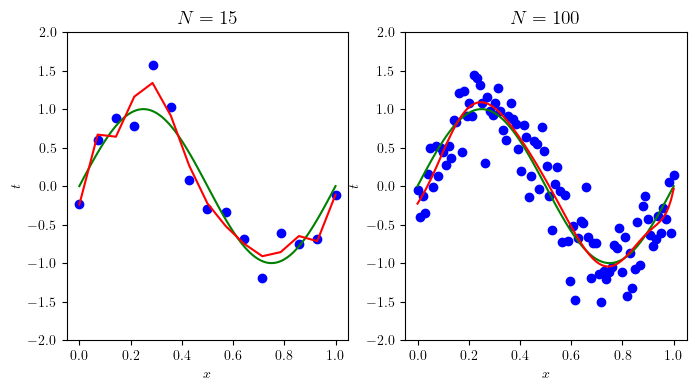

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))

for i, N in enumerate([15, 100]):
    inputs, outputs = gen_data(N)
    features = PolynomialFeatures(9)
    model = LinearRegression(9, features.transform)
    model.fit(inputs, outputs)
    y = model.run(inputs)
    subplot = ax[i]
    subplot.set(xlabel=r'$x$', ylabel = r'$t$')
    subplot.plot(curve_x, curve_y, c = 'g')
    subplot.scatter(inputs, outputs, c = 'b')
    subplot.plot(inputs, y, c = 'r')
    subplot.set_ylim(-2,2)
    subplot.set_title(r'$N={}$'.format(N), fontsize = 14) 

plt.show()

One can add Regularization (Shrinkage methods) to reduce overfitting for smaller model complexities (Note, below due to matrix precision issues I have chosen 
$\lambda = -8$ instead of the example in the text)

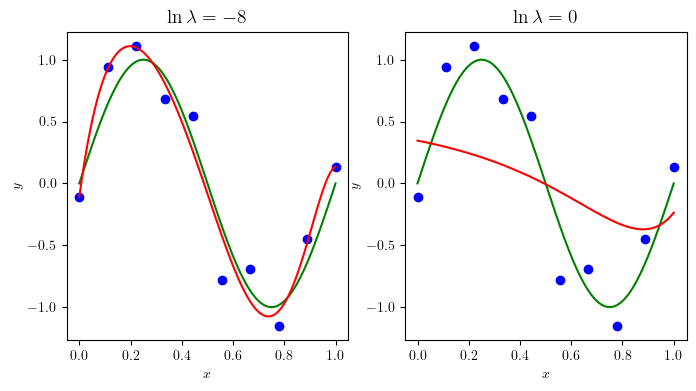

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
logalpha = [-8, 0]

for i, alpha in enumerate([np.float64(10**(-8)), np.float64(1)]):
    features = PolynomialFeatures(9)
    model = LinearRegression(9, features.transform, 'Ridge', alpha)
    model.fit(train_in, train_out)
    y = model.run(curve_x)
    subplot = ax[i]
    subplot.set(xlabel=r'$x$', ylabel=r'$y$')
    subplot.plot(curve_x, curve_y, c = 'g')
    subplot.scatter(train_in, train_out, c = 'b')
    subplot.plot(curve_x, y, c = 'r')
    subplot.set_title(r'$\ln\lambda={}$'.format(logalpha[i]), fontsize = 14)
plt.show()